Applied Machine Learning - Project 3

Dimosthenis Plavos-3200156 

# Roget's Thesaurus in the 21st Century

## Imports

In [1]:
import re
import json
import csv
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier 

## 1. Get Roget's Thesaurus Classification

You can find [Roget's Thesaurus classification online at the Wikipedia](https://en.wiktionary.org/wiki/Appendix:Roget%27s_thesaurus_classification). You must download the categorisation (and the words belonging in each category), save them and store them in the way that you deem most convenient for processing.

Solution:

My goal in this task is to process the text and create a json file which will be concenient to be processed for the next tasks. What I am doing in this task is the following:
1) In the "extract_words" function, I split the text according to its nesting which is CLASS > ( DIVISION ) > SECTION > OUTSIDE_WORD > INSIDE_WORDS. <br>
- The OUTSIDE_WORD is one of the main words that the lexicon has. 
- The INSIDE_WORDS are the related words to this one, according to the lexicon.
2) After splitting the whole text, I have to process the OUTSIDE_WORD (which can be a word, 2 words separated by coma or a phrase). <br>
The function "edit_outside_text" does this. After processing, i will have only the word itself, without unnecessary symbols i.e. <br>

3) Also after splitting the whole text, I have to process the INSIDE_WORDS. At first, I get them as a whole string. <br>
Then, I process this string so that i dump symbols, (), [], and phrases which usually are just repeating the already existing words and add complexity for no reason. Eventually, i will have a list of "important words" that i will use afterwards to take the word embedding of the OUTSIDE_WORD.


In [2]:
def edit_outside_text(text):
    # Delete the [...] parts
    text_without_brackets = re.sub(r'\[.*?\]', '', text)
    
    # Delete any numerical value
    text_without_numbers = re.sub(r'\b\d+[a-zA-Z]?\b\.?', '', text_without_brackets)
    
    # Process for splitting
    text_prepared_for_splitting = re.sub(r'([,\.])(?=\S)', r' \1 ', text_without_numbers)
    text_prepared_for_splitting = re.sub(r'(?<=\S)([&,\.])', r' \1 ', text_prepared_for_splitting)
    words = text_prepared_for_splitting.split()
    
    if len(words) == 1:
        return words[0]
    else:
        edited_text = ' '.join(words)

        # Remove Unicode characters
        edited_text = re.sub(r'[^\x00-\x7F]+', '', edited_text)
        # Remove "&c" if present in the text
        edited_text = edited_text.replace("&c", "")

        # Replace dot or ampersand with comma if two words are separated by them
        edited_text = re.sub(r'(\w+)\s*[&.]\s*(\w+)', r'\1, \2', edited_text)
        
        phrases = edited_text.split()
        for i, phrase in enumerate(phrases):
            phrases[i] = phrase.replace('.', ',').replace('&', ',')

        edited_text = ' '.join(phrases)
        text = ' '.join(phrase.strip() for phrase in phrases)
        # # Delete the last character if it is a comma
        # text = re.sub(r',$', '', text)
        # Trim leading and trailing spaces
        text = text.strip()
        
        return text


def edit_inside_text(text):
    # Remove text enclosed within square brackets
    text_without_brackets = re.sub(r'\[.*?\]', '', text)
    
    # Split the description using predefined separators
    separators = [';', ',', '\.', '\n', '&', '\?']
    escaped_separators = '|'.join(separators)
    parts = re.split(escaped_separators, text_without_brackets)
    
    filtered_words = []
    non_real_words = {'ens', 'esse', 'adj', 'adv', 'phr', 'v', 'n', 'lat', 'c'}
    
    # Filtering words based on criteria
    for part in parts:
        word = part.strip().lower()
        if word and not re.search(r'\d', word) and word not in non_real_words and re.match(r'^[a-zA-Z]+$', word):
            filtered_words.append(word)
    
    # Deduplicate while preserving order
    final_words = list(dict.fromkeys(filtered_words))
    
    return final_words


def extract_words(file_path):
    structured_data = {}
    current_class = None
    current_section = None
    current_division = None
    outside_text = ""
    inside_text = ""  
    
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        line = line.strip()

        if line.startswith("CLASS"):
            current_class = line
            structured_data[current_class] = {}
            current_division = None  # Reset current_division when a new class starts
        elif "DIVISION" in line:
            current_division = line
            if current_class is not None:
                structured_data[current_class][current_division] = {}
        elif line.startswith("SECTION"):
            current_section = line
            if current_class is not None:
                if current_division is not None:
                    if current_division not in structured_data[current_class]:
                        structured_data[current_class][current_division] = {}
                    structured_data[current_class][current_division][current_section] = {}
                else:
                    structured_data[current_class][current_section] = {}
        elif line.startswith("#"):
            inside_text = "" 
            outside_text = line.split("--")[0][1:].strip()
            inside_text = line.split("--")[1].strip() if "--" in line else ""

        
            if current_section is not None and outside_text:
                edited_outside_text = edit_outside_text(outside_text)
                if current_division is not None:
                    target = structured_data[current_class][current_division][current_section]
                else:
                    target = structured_data[current_class].get(current_section, {})
                target[edited_outside_text] = edit_inside_text(inside_text)
        elif inside_text:
            inside_text += " " + line.strip()
            target[edited_outside_text] = edit_inside_text(inside_text)

    return structured_data


file_path = 'words.txt'

# Extract structured data from the file
structured_data = extract_words(file_path)

# Save the structured data to a JSON file
with open('structured_data.json', 'w') as outfile:
    json.dump(structured_data, outfile, indent=4)

print("Data extraction complete. The structured data has been saved to 'structured_data.json'.")

Data extraction complete. The structured data has been saved to 'structured_data.json'.


Besided creating this json file, I will also create a csv file which will have 2 columns:
- The word (OUTSIDE_WORD)
- The correct class  (label) according to the lexicon.

It will be useful for later on.

In [3]:
# Function to convert Roman numerals to Arabic numerals
def roman_to_arabic(roman):
    roman_numerals = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    result = 0
    i = 0
    while (i < len(roman)):
        if (i+1 < len(roman)) and (roman_numerals[roman[i]] < roman_numerals[roman[i+1]]):
            result += roman_numerals[roman[i+1]] - roman_numerals[roman[i]]
            i += 2
        else:
            result += roman_numerals[roman[i]]
            i += 1
    return result

# Load the structured data from the JSON file
with open('structured_data.json', 'r') as file:
    structured_data = json.load(file)

# Define the path for the output CSV file
csv_file_path = 'csv_structured_data.csv'

# Open the CSV file in write mode
with open(csv_file_path, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Word", "Class"])  # Write the header row

    # Function to process each section and write to CSV
    def process_section(section_words, class_name):
        # Convert class name from Roman to Arabic numerals
        class_number = roman_to_arabic(class_name.split(' ')[-1])
        for word in section_words.keys():
            writer.writerow([word, class_number])

    # Iterate through each class
    for class_name, content in structured_data.items():
        # Check if we're looking at divisions or direct sections
        for key, value in content.items():
            if 'DIVISION' in key:  # If it's a division, iterate through its sections
                for section_name, section_words in value.items():
                    process_section(section_words, class_name)
            elif 'SECTION' in key:  # Directly a section under a class
                process_section(value, class_name)


## 2. Get Word Embeddings

You will embeddings for the word entries in Roget's Thesaurus. It is up to you to find the embeddings; you can use any of the available models. Older models like word2vec, GloVe, BERT, etc., may be easier to use, but recent models like Llama 2 and Mistral have been trained on larger corpora. OpenAI and Google offer their embeddings through APIs, but they are not free.

You should think about how to store the embeddings you retrieve. You may use plain files (e.g., JSON, CSV) and vanilla Python, or a vector database.

### Solution: 
What we care about at this point is to take the word embeddings of the OUTSIDE_WORDS. <br>

But why do we need the INSIDE_WORDS? <br>

Because they are related to their OUTSIDE_WORD and by using them, we can take a more accurate word embedding for the OUTSIDE_WORDS. This is very helpful for some words that have a double meaning or their meaning is depending on how you use them.

## CREATE WORD EMBEDDINGS

In [4]:
# Load the Word2Vec model
model_path = 'GoogleNews-vectors-negative300.bin.gz' # This file is not uploaded to the github repo because it is too heavy. I have downloaded it only locally.
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Load the structured JSON file with outside and nested words
with open('structured_data.json', 'r') as file:
    structured_data = json.load(file)

# Prepare to store the average embeddings for outside words
average_embeddings = {}

# Function to safely get an embedding
def get_embedding(word, model):
    return model[word] if word in model else None

def process_nested_words(outside_word, nested_words, model, average_embeddings):
    embeddings = []
    outside_embedding = get_embedding(outside_word.lower(), model)
    if outside_embedding is not None:
        embeddings.append(outside_embedding)
    for word in nested_words:
        word_embedding = get_embedding(word.lower(), model)
        if word_embedding is not None:
            embeddings.append(word_embedding)
    if embeddings:
        average_embedding = np.mean(embeddings, axis=0)
        average_embeddings[outside_word.lower()] = average_embedding.tolist()
    else:
        # We check if the failure happened on a phrase where it is really difficult to find word_embedding using the method get_embedding
        if ' ' in outside_word:
            words = outside_word.split()
            word_embeddings = []
            for word in words:
                word_embedding = get_embedding(word, model)
                if word_embedding is not None:
                    embeddings.append(word_embedding)
            if embeddings:
                average_embedding = np.mean(embeddings, axis=0)
                average_embeddings[outside_word.lower()] = average_embedding.tolist()
            

for class_name, content in structured_data.items():
    if isinstance(content, dict):  # If the content under each class is a dictionary, possibly of divisions or sections
        for division_or_section_name, sections_or_categories in content.items():
            if isinstance(sections_or_categories, dict):  # We have divisions that contain sections or directly sections
                # Check if it's a division by trying to access a known section format or any other distinguishing feature
                is_division = any(isinstance(val, dict) for val in sections_or_categories.values()) 
                if is_division:  # If true, it's a division
                    for section_name, categories in sections_or_categories.items():
                        for outside_word, nested_words in categories.items():
                            process_nested_words(outside_word, nested_words, model, average_embeddings)
                else:  # Directly sections, no division
                    categories = sections_or_categories
                    for outside_word, nested_words in categories.items():
                        process_nested_words(outside_word, nested_words, model, average_embeddings)
            

# Save the average embeddings for outside words to a new JSON file, with lowercase keys
with open('word_embeddings.json', 'w') as outfile:
    json.dump(average_embeddings, outfile, ensure_ascii=False, indent=4)

print("Average word embeddings for outside words saved to word_embeddings.json with lowercase keys.")

Average word embeddings for outside words saved to word_embeddings.json with lowercase keys.


## 3. Clustering

With the embeddings at hand, you can check whether unsupervised Machine Learning methods can arrive at classifications that are comparable to the Roget's Thesaurus Classification. You can use any clustering method of your choice (experiment freely). You must decide how to measure the agreement between the clusters you find and the classes defined by Roget's Thesaurus and report your results accordingly. The comparison will be at the class level (six classes) and the section / division level (so there must be two different clusterings, unless you can find good results with hierarchical clustering).

### K-means using 6 clusters for CLASS level

/Users/dplavos/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.042623597849702634


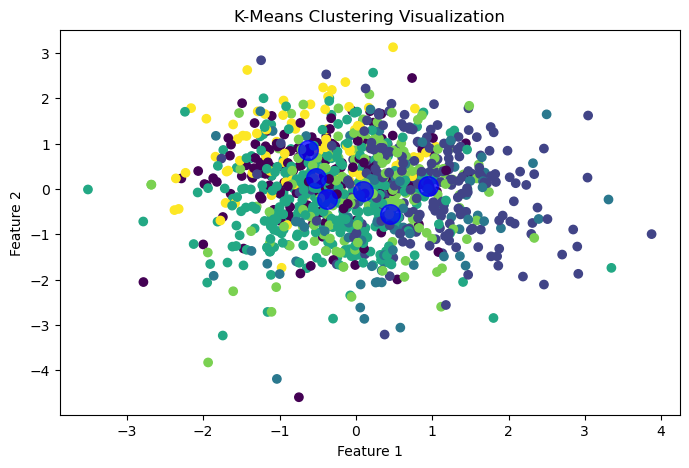

In [5]:
# Load word embeddings
with open('word_embeddings.json', 'r') as file:
    embeddings = json.load(file)

# Load structured data
df = pd.read_csv('csv_structured_data.csv')

# Filter the DataFrame to only include words present in the embeddings
filtered_df = df[df['Word'].apply(lambda x: x.lower() in embeddings)]

# Check if there are enough samples for the intended number of clusters
n_clusters = 6  # Intended number of clusters
available_samples = len(filtered_df)

# Adjust the number of clusters if necessary
if available_samples < n_clusters:
    print(f"Warning: Only {available_samples} samples available, adjusting the number of clusters to {available_samples - 1}.")
    n_clusters = max(2, available_samples - 1)  # Ensure at least 2 clusters for silhouette score calculation

# Extract embeddings for filtered words
X = [embeddings[word.lower()] for word in filtered_df['Word']]

# Proceed with clustering if we have enough samples
if available_samples >= n_clusters:
    # Standardize the embeddings
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)

    # Assign cluster labels to the filtered DataFrame
    filtered_df['Cluster'] = kmeans.labels_

    # Merge the cluster labels back to the original DataFrame
    final_df = pd.merge(df, filtered_df[['Word', 'Cluster']], on='Word', how='left')

    # Now `final_df` contains your original data along with the cluster labels for words that were clustered
    final_df.to_csv('structured_data_with_clusters.csv', index=False)

    # Calculate the silhouette score for the scaled data and assigned labels
    if n_clusters > 1:  # Silhouette score calculation is meaningful only if we have more than one cluster
        silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
        print(f'Silhouette Score: {silhouette_avg}')
else:
    print("Not enough samples for clustering.")


# Plotting the clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_, cmap='viridis')

# Plotting the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=200, alpha=0.75)

plt.title('K-Means Clustering Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### K-means using 24 clusters for DIVISION / SECTION level

Proceeding with 24 clusters.


/Users/dplavos/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


New Silhouette Score with 24 clusters: 0.03575269682670508


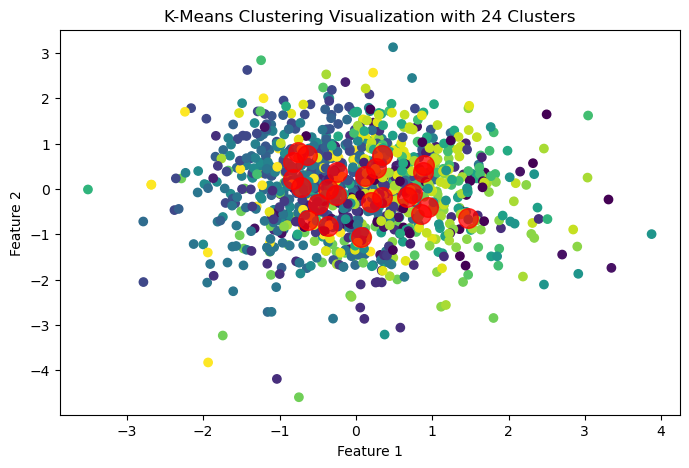

In [6]:
# Intended number of clusters for the new analysis
n_clusters_new = 24  # Desired number of clusters

# Check if there are enough samples for the intended number of clusters
if available_samples < n_clusters_new:
    print(f"Warning: Only {available_samples} samples available, adjusting the number of clusters to {available_samples - 1}.")
    n_clusters_new = max(2, available_samples - 1)  # Ensure at least 2 clusters for silhouette score calculation
else:
    print(f"Proceeding with {n_clusters_new} clusters.")

# Perform KMeans clustering with the new number of clusters
kmeans_new = KMeans(n_clusters=n_clusters_new, random_state=42)
kmeans_new.fit(X_scaled)

# Assign the new cluster labels to the filtered DataFrame
filtered_df['Cluster_New'] = kmeans_new.labels_

# Merge the new cluster labels back to the original DataFrame
final_df_new = pd.merge(df, filtered_df[['Word', 'Cluster_New']], on='Word', how='left')

# Save the updated DataFrame with the new cluster labels
final_df_new.to_csv('structured_data_with_24_clusters.csv', index=False)

# Calculate the silhouette score for the new clustering, if applicable
if n_clusters_new > 1:
    silhouette_avg_new = silhouette_score(X_scaled, kmeans_new.labels_)
    print(f'New Silhouette Score with {n_clusters_new} clusters: {silhouette_avg_new}')

# Plotting the clusters with the new number of clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_new.labels_, cmap='viridis')

# Plotting the centroids for the new clustering
centers_new = kmeans_new.cluster_centers_
plt.scatter(centers_new[:, 0], centers_new[:, 1], c='red', s=200, alpha=0.75)

plt.title(f'K-Means Clustering Visualization with {n_clusters_new} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


## 4. Class Prediction

Now we flip over to supervised Machine Learning methods. You must experiment and come up with the best classification method, whose input will be a word and its target will be its class, or its section / devision (so there must be two different models).

### Solution

For this purpose i will apply 3 algorithms for supervised learning: KNN, MLP classifier and LSTM.

## KNN

In [7]:
# Load structured data
structured_data_path = 'csv_structured_data.csv'
structured_data = pd.read_csv(structured_data_path)

# Load word embeddings
word_embeddings_path = 'word_embeddings.json'
with open(word_embeddings_path, 'r') as file:
    word_embeddings = json.load(file)

# Prepare features and labels
X_list = []
y_list = []
for _, row in structured_data.iterrows():
    word = row['Word']
    if word.lower() in word_embeddings:
        X_list.append(word_embeddings[word.lower()])
        y_list.append(row['Class'])
    else:
        print(f"The word {word} does not have a word embedding.")

X = np.array(X_list)
y = np.array(y_list)

# Only proceed if there are words with embeddings
if len(X) > 0 and len(y) > 0:

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.55)  # Adjust n_components based on your requirement
    X_pca = pca.fit_transform(X_scaled)
    print(f"Reduced dimensions from {X_scaled.shape[1]} to {X_pca.shape[1]}")
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=True, random_state=42)

    # Initialize KNN model
    knn = KNeighborsClassifier(n_neighbors=8)

    # Train the KNN model
    knn.fit(X_train, y_train)

    # Predict on the training set and calculate accuracy
    y_train_pred = knn.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Set Accuracy: {train_accuracy}")

    # Predict on the test set and calculate accuracy
    y_pred = knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Testing Set Accuracy: {test_accuracy}")

    # Generate and print the classification report for the testing set
    print("Classification Report for Testing Set:")
    print(classification_report(y_test, y_pred))
else:
    print("No words with embeddings found for training.")

Reduced dimensions from 300 to 26
Training Set Accuracy: 0.7575342465753425
Testing Set Accuracy: 0.6528662420382165
Classification Report for Testing Set:
              precision    recall  f1-score   support

           1       0.51      0.75      0.60        55
           2       0.64      0.57      0.60        49
           3       0.94      0.68      0.79        47
           4       0.73      0.67      0.70        49
           5       0.57      0.64      0.60        61
           6       0.78      0.60      0.68        53

    accuracy                           0.65       314
   macro avg       0.69      0.65      0.66       314
weighted avg       0.68      0.65      0.66       314



## MLP Classifier

In [8]:
# Load structured data
structured_data_path = 'csv_structured_data.csv'
structured_data = pd.read_csv(structured_data_path)

# Load word embeddings
word_embeddings_path = 'word_embeddings.json'
with open(word_embeddings_path, 'r') as file:
    word_embeddings = json.load(file)

# Prepare features and labels
X_list = []
y_list = []
for _, row in structured_data.iterrows():
    word = row['Word']
    if word.lower() in word_embeddings:
        X_list.append(word_embeddings[word.lower()])
        y_list.append(row['Class'])
    else:
        print(f"The word {word} does not have a word embedding.")

X = np.array(X_list)
y = np.array(y_list)

# Proceed only if there are words with embeddings
if len(X) > 0 and len(y) > 0:
    # Normalize features before applying PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.55)  # Adjust n_components based on your requirement
    X_pca = pca.fit_transform(X_scaled)
    print(f"Reduced dimensions from {X_scaled.shape[1]} to {X_pca.shape[1]}")

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=True, random_state=42)

    # Initialize MLP model
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, alpha=0.001, random_state=42, early_stopping=True)

    # Train the MLP model
    mlp.fit(X_train, y_train)

    # Predict on the training set and calculate accuracy
    y_train_pred = mlp.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Set Accuracy: {train_accuracy}")

    # Predict on the test set and calculate accuracy
    y_pred = mlp.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Testing Set Accuracy: {test_accuracy}")

    # Generate and print the classification report for the testing set
    print("Classification Report for Testing Set:")
    print(classification_report(y_test, y_pred))
else:
    print("No words with embeddings found for training.")

Reduced dimensions from 300 to 26
Training Set Accuracy: 0.8287425149700599
Testing Set Accuracy: 0.7464114832535885
Classification Report for Testing Set:
              precision    recall  f1-score   support

           1       0.72      0.67      0.69        39
           2       0.87      0.69      0.77        29
           3       0.76      0.86      0.81        29
           4       0.66      0.72      0.69        32
           5       0.71      0.82      0.76        39
           6       0.81      0.73      0.77        41

    accuracy                           0.75       209
   macro avg       0.75      0.75      0.75       209
weighted avg       0.75      0.75      0.75       209



## LSTM

In [9]:
# Load structured data
structured_data_path = 'csv_structured_data.csv'
structured_data = pd.read_csv(structured_data_path)

# Load word embeddings
word_embeddings_path = 'word_embeddings.json'
with open(word_embeddings_path, 'r') as file:
    word_embeddings = json.load(file)

# Prepare features and labels
X_list = []
y_list = []
for _, row in structured_data.iterrows():
    word = row['Word']
    if word.lower() in word_embeddings:
        X_list.append(word_embeddings[word.lower()])
        y_list.append(row['Class'])
    else:
        print(f"The word {word} does not have a word embedding.")

# Convert lists to NumPy arrays
X = np.array(X_list)
y = np.array(y_list)

# Convert labels to categorical (one-hot encoding)
y = to_categorical(y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# LSTM expects input to be in the shape of (number of samples, time steps, features per step)
n_features = X_train.shape[1]
X_train = np.reshape(X_train, (X_train.shape[0], 1, n_features))
X_test = np.reshape(X_test, (X_test.shape[0], 1, n_features))

# Define the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(1, n_features)))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generate and print the classification report
print("Classification Report for Testing Set:")
print(classification_report(y_test_classes, y_pred_classes))

Epoch 1/100
21/21 - 1s - loss: 1.8802 - accuracy: 0.3099 - val_loss: 1.8015 - val_accuracy: 0.3713 - 912ms/epoch - 43ms/step
Epoch 2/100
21/21 - 0s - loss: 1.7224 - accuracy: 0.4521 - val_loss: 1.6462 - val_accuracy: 0.4790 - 37ms/epoch - 2ms/step
Epoch 3/100
21/21 - 0s - loss: 1.5475 - accuracy: 0.5449 - val_loss: 1.4700 - val_accuracy: 0.5090 - 38ms/epoch - 2ms/step
Epoch 4/100
21/21 - 0s - loss: 1.3493 - accuracy: 0.6482 - val_loss: 1.2923 - val_accuracy: 0.6407 - 39ms/epoch - 2ms/step
Epoch 5/100
21/21 - 0s - loss: 1.1524 - accuracy: 0.6916 - val_loss: 1.1403 - val_accuracy: 0.6587 - 40ms/epoch - 2ms/step
Epoch 6/100
21/21 - 0s - loss: 0.9930 - accuracy: 0.7410 - val_loss: 1.0238 - val_accuracy: 0.6826 - 43ms/epoch - 2ms/step
Epoch 7/100
21/21 - 0s - loss: 0.8690 - accuracy: 0.7515 - val_loss: 0.9393 - val_accuracy: 0.7006 - 41ms/epoch - 2ms/step
Epoch 8/100
21/21 - 0s - loss: 0.7877 - accuracy: 0.7710 - val_loss: 0.8868 - val_accuracy: 0.7066 - 42ms/epoch - 2ms/step
Epoch 9/100
21

## Conlcusion

It seems that algorithm that use Neural Networks have better performance!